The dataset is credited from https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

First，get the dataset from Kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huangspray","key":"6fa5bed5ff41875d1a56a2ea015c644b"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           2424  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           9165  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Turnout rates           4KB  2020-11-26 00:21:15           2927  
afrniomelo/3w-dataset                                        3W Dataset - Undesirable events in oil wells   658MB  2020-11-21 21:22:49            454  
patrickb1912/ipl-complete-dataset-20082020                   IPL Complete Dataset (2008-

In [ ]:
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

100% 6.24G/6.26G [02:17<00:00, 113MB/s] 
100% 6.26G/6.26G [02:17<00:00, 49.0MB/s]


In [ ]:
!unzip CORD-19-research-challenge.zip -d CORD-19-research-challenge

Streaming output truncated to the last 5000 lines.
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675279.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675280.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675281.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675282.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675286.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675288.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675290.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675291.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675292.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675293.xml.json  
  inflating: CORD-19-research-challenge/document_parses/pmc_json/PMC7675296.xml

In [ ]:
##Install the packages 
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers


     |████████████████████████████████| 1.0MB 8.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993459 sha256=76b3d9ca5f21b2e639766a6e669992945becbb52f149337b658efbb9615e2bfb
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
  Created wheel for language-detector: filename=language_detector-5.0.2-cp36-none-any.whl size=7054 sha256=88cd80314c6e289612346c057659553720a5b79203b25c963e2df29253a20101
  Stored in directory: /root/.cache/pip/wheels/7d/37/fa/2098a4aa6c0d94d6ddff0d3a79669e12bc4f7baca8a760b3db
Successfully built language-detector
     |████████████████████████████████| 2.6MB 9.7MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 1.3MB 11.6MB/s 
     |████████████████████████████████| 1.1MB 29.1MB/s 
     |████████████████████████████████| 890kB 42.5MB/s 
     |████████████████████████████████| 2.9MB 18.5MB/s 

In [ ]:
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

In [ ]:
!ls 

CORD-19-research-challenge	kaggle.json
CORD-19-research-challenge.zip	sample_data


In [ ]:
meta = pd.read_csv("CORD-19-research-challenge/metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(meta.shape)

(381817, 19)


Topic Searching

In [ ]:
### first filter by meta file. select only papers after 2020
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = (pd.DatetimeIndex(meta['publish_time']).year)
meta["publish_month"] = (pd.DatetimeIndex(meta['publish_time']).month)
meta = meta[meta["publish_year"] == 2020]
meta = meta[meta["publish_month"] >= 6]
print(meta.shape[0], " papers are available after 2020 June 1.")

104327  papers are available after 2020 June 1.


In [ ]:
#count how many has abstract
count = 0
index = []
for i in range(len(meta)):
    if type(meta.iloc[i, 8])== float:
        count += 1
    else:
        index.append(i)

print(len(index), " papers have abstract available.")

76274  papers have abstract available.


In [ ]:
##extract the abstract to pandas 
documents = meta.iloc[index, 8]
documents=documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
print(documents.head(5))

                                            abstract  index
0  In this paper, we have proposed a two-phase pr...      0
1  In this paper, we consider the problem of acce...      1
2  DNA vaccines expressing codon-optimized Venezu...      2
3  As computational biologists continue to be inu...      3
4  PURPOSE: We recently identified disorganized m...      4


In [ ]:
##Data Preprocessing
np.random.seed(400)
stemmer = SnowballStemmer("english")

##lemmatize and stemming

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
##preprocess all abstracts
processed_docs = documents['abstract'].map(preprocess)

In [ ]:
##create dictionary based on the preprocessed_documents
dictionary = gensim.corpora.Dictionary(processed_docs)

##check the dictionary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 adapt
1 approach
2 avail
3 base
4 combin
5 complet


In [ ]:
## remove extreme words (very common and very rare)
dictionary.filter_extremes(no_below=5, no_above=0.5)

##create bag-of-word model for each documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
#create tf-idf from bow_corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#preview the corpus_tfidf
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.1073940953758284), (1, 0.07240870980486783), (2, 0.07243055795889565), (3, 0.05003706344291348), (4, 0.09125397992902305), (5, 0.0951469405640198), (6, 0.13047307134653144), (7, 0.13565124867646114), (8, 0.049202969624954386), (9, 0.18555448450207346), (10, 0.09677577648811113), (11, 0.13033899089614506), (12, 0.11597994798693985), (13, 0.0972914901410188), (14, 0.3669614696270773), (15, 0.1238658901330221), (16, 0.0863295207688095), (17, 0.10047530691657239), (18, 0.1410627350578965), (19, 0.05925485106094034), (20, 0.0755568814616205), (21, 0.1272664251218605), (22, 0.08503604218850774), (23, 0.2807360266089274), (24, 0.32871518048853277), (25, 0.1896916313645228), (26, 0.21368683730334204), (27, 0.08726377178594444), (28, 0.05067401726100425), (29, 0.10822658759058894), (30, 0.13798032257553558), (31, 0.16725100498093726), (32, 0.14487583905848447), (33, 0.5079773009916443)]


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=5, 
                                       id2word = dictionary, 
                                       passes = 50, 
                                       workers=4) 

In [ ]:
for id, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(id, topic))
    print("\n")

Topic: 0 
Words: 0.018*"model" + 0.009*"data" + 0.007*"base" + 0.007*"method" + 0.007*"time" + 0.007*"result" + 0.006*"effect" + 0.006*"predict" + 0.005*"differ" + 0.005*"studi"


Topic: 1 
Words: 0.017*"sar" + 0.017*"cell" + 0.011*"protein" + 0.009*"virus" + 0.009*"infect" + 0.009*"drug" + 0.008*"immun" + 0.008*"diseas" + 0.007*"vaccin" + 0.007*"viral"


Topic: 2 
Words: 0.017*"health" + 0.015*"pandem" + 0.008*"care" + 0.007*"studi" + 0.006*"social" + 0.005*"public" + 0.005*"provid" + 0.005*"result" + 0.005*"impact" + 0.005*"research"


Topic: 3 
Words: 0.031*"sar" + 0.030*"infect" + 0.021*"case" + 0.019*"test" + 0.018*"patient" + 0.018*"diseas" + 0.015*"coronavirus" + 0.012*"respiratori" + 0.011*"sever" + 0.010*"posit"


Topic: 4 
Words: 0.054*"patient" + 0.014*"studi" + 0.012*"hospit" + 0.011*"clinic" + 0.010*"risk" + 0.009*"group" + 0.009*"associ" + 0.009*"outcom" + 0.009*"treatment" + 0.009*"diseas"




In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=5, 
                                             id2word = dictionary, 
                                             passes = 50, 
                                             workers=4)

In [ ]:
for id, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} Word: {}".format(id, topic))
    print("\n")

Topic: 0 Word: 0.013*"patient" + 0.005*"sever" + 0.005*"hospit" + 0.004*"clinic" + 0.004*"mortal" + 0.004*"diseas" + 0.004*"symptom" + 0.004*"case" + 0.004*"respiratori" + 0.004*"sar"


Topic: 1 Word: 0.009*"sar" + 0.008*"cell" + 0.006*"protein" + 0.005*"virus" + 0.005*"immun" + 0.005*"drug" + 0.005*"vaccin" + 0.005*"viral" + 0.004*"antibodi" + 0.004*"infect"


Topic: 2 Word: 0.006*"model" + 0.004*"detect" + 0.003*"sampl" + 0.003*"test" + 0.003*"propos" + 0.003*"imag" + 0.003*"temperatur" + 0.003*"aerosol" + 0.003*"correct" + 0.003*"mask"


Topic: 3 Word: 0.005*"research" + 0.004*"student" + 0.004*"learn" + 0.003*"paper" + 0.003*"educ" + 0.003*"health" + 0.003*"technolog" + 0.003*"articl" + 0.003*"public" + 0.003*"social"


Topic: 4 Word: 0.005*"health" + 0.004*"pandem" + 0.004*"care" + 0.003*"countri" + 0.003*"case" + 0.003*"lockdown" + 0.003*"social" + 0.003*"measur" + 0.003*"mental" + 0.003*"popul"




In [ ]:
lda_topics = pd.DataFrame(columns = ["topic1", "topic2", "topic3", "topic4", "topic5"])
lda_tfidf_topics = pd.DataFrame(columns = ["topic1", "topic2", "topic3", "topic4", "topic5"])
for i in range(len(bow_corpus)):
    
    lda_topics.loc[i] = [0] * 5
    
    output = lda_model.get_document_topics(bow_corpus[i])
    for j in range(len(output)):
        a = output[j][0]
        b = output[j][1]
        lda_topics.iloc[i,a] = b
    

for i in range(len(corpus_tfidf)):
    lda_tfidf_topics.loc[i] = [0] * 5
    
    output = lda_model_tfidf.get_document_topics(corpus_tfidf[i])
    for k in range(len(output)):
        a = output[k][0]
        b = output[k][1]
        lda_tfidf_topics.iloc[i, a] = b

In [ ]:
## pick the final topic for each abstract based on max-probability
for i in range(5):
    lda_topics.iloc[:, i] = lda_topics.iloc[:, i].astype('float64', copy=False)
    
lda_topics["final_topic"] = lda_topics.iloc[:, :5].idxmax(axis=1)

for i in range(5):
    lda_tfidf_topics.iloc[:, i] = lda_tfidf_topics.iloc[:, i].astype('float64', copy=False)

lda_tfidf_topics["final_topic"] =lda_tfidf_topics.iloc[:, :5].idxmax(axis=1)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lda_topics.iloc[:, :5])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 76274 samples in 0.109s...
[t-SNE] Computed neighbors for 76274 samples in 2.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 76274
[t-SNE] Computed conditional probabilities for sample 2000 / 76274
[t-SNE] Computed conditional probabilities for sample 3000 / 76274
[t-SNE] Computed conditional probabilities for sample 4000 / 76274
[t-SNE] Computed conditional probabilities for sample 5000 / 76274
[t-SNE] Computed conditional probabilities for sample 6000 / 76274
[t-SNE] Computed conditional probabilities for sample 7000 / 76274
[t-SNE] Computed conditional probabilities for sample 8000 / 76274
[t-SNE] Computed conditional probabilities for sample 9000 / 76274
[t-SNE] Computed conditional probabilities for sample 10000 / 76274
[t-SNE] Computed conditional probabilities for sample 11000 / 76274
[t-SNE] Computed conditional probabilities for sample 12000 / 76274
[t-SNE] Computed conditional probabilities for sa

In [ ]:
##create dataframe with TSNE results
tsne_df = pd.DataFrame()
tsne_df['tsne-one'] = tsne_results[:,0]
tsne_df['tsne-two'] = tsne_results[:,1]

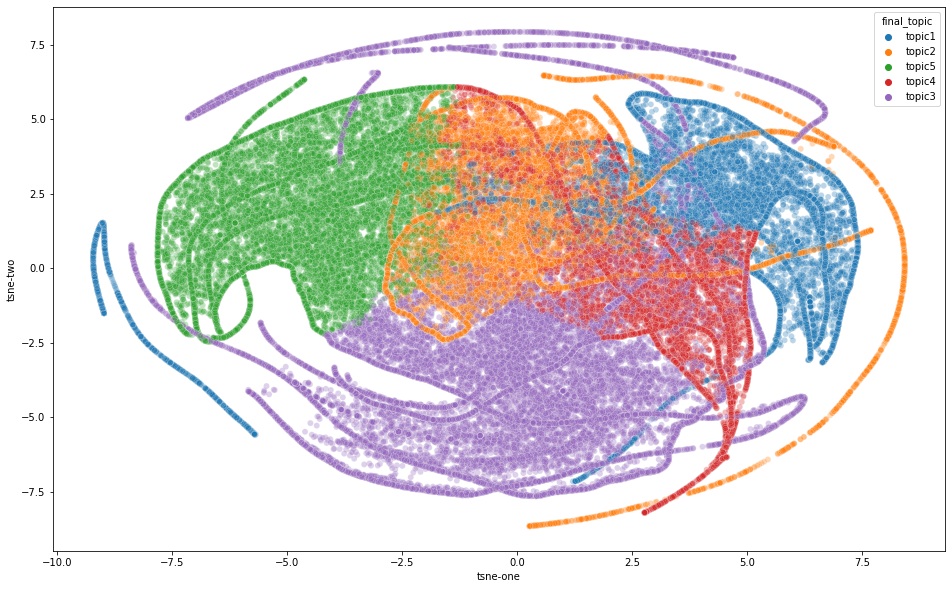

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue=lda_topics.iloc[:, 5].replace({"red": "topic1", "blue" :"topic2", "green": "topic3", "yellow": "topic4", "black": "topic5"}),
    data=tsne_df,
    legend="full",
    alpha=0.3)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lda_tfidf_topics.iloc[:, :5])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 76274 samples in 0.091s...
[t-SNE] Computed neighbors for 76274 samples in 2.940s...
[t-SNE] Computed conditional probabilities for sample 1000 / 76274
[t-SNE] Computed conditional probabilities for sample 2000 / 76274
[t-SNE] Computed conditional probabilities for sample 3000 / 76274
[t-SNE] Computed conditional probabilities for sample 4000 / 76274
[t-SNE] Computed conditional probabilities for sample 5000 / 76274
[t-SNE] Computed conditional probabilities for sample 6000 / 76274
[t-SNE] Computed conditional probabilities for sample 7000 / 76274
[t-SNE] Computed conditional probabilities for sample 8000 / 76274
[t-SNE] Computed conditional probabilities for sample 9000 / 76274
[t-SNE] Computed conditional probabilities for sample 10000 / 76274
[t-SNE] Computed conditional probabilities for sample 11000 / 76274
[t-SNE] Computed conditional probabilities for sample 12000 / 76274
[t-SNE] Computed conditional probabilities for sa

In [ ]:
##create dataframe with TSNE results
tsne_df = pd.DataFrame()
tsne_df['tsne-one'] = tsne_results[:,0]
tsne_df['tsne-two'] = tsne_results[:,1]

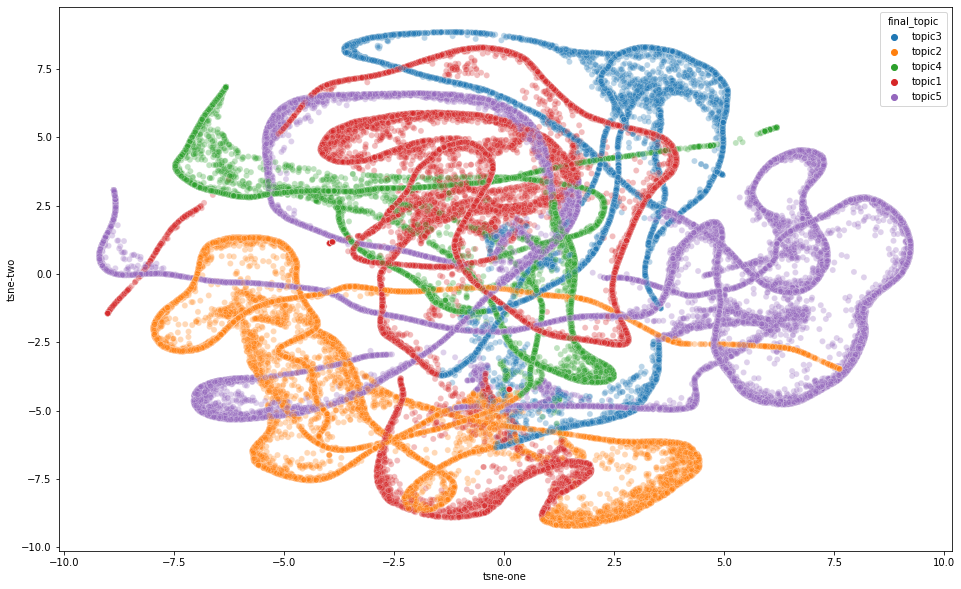

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue=lda_tfidf_topics.iloc[:, 5].replace({"red": "topic1", "blue" :"topic2", "green": "topic3", "yellow": "topic4", "black": "topic5"}),
    data=tsne_df,
    legend="full",
    alpha=0.3)